# 목표
- 모델링 해보기
- **⭐ 어떤 형태가 성능이 잘 나오는지 확인⭐**

~~솔직히 어느정도 정형화 되어있다..~~

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# 미리 이용할 폴더의 path를 정합니다.
# 파일 집어넣을곳 폴더자체를 지정합니다.

path = '/content/drive/MyDrive/AIVLE/AI_미니프로젝트 1차_실습자료/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터 준비

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 자동완성 안될까봐 미리 설정하는 것
#%config Completer.use_jedi = False

In [3]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [4]:
# 주어진 데이터 셋을 불러오세요.(3개)
df_train  = pd.read_csv(path + 'data01_train.csv')
df_test = pd.read_csv(path + 'data01_test.csv')
df_feature = pd.read_csv(path + 'features.csv')

#불필요한 칼럼을 삭제하세요.
df_train = df_train.drop('subject', axis=1)
df_test = df_test.drop('subject', axis=1)
df_train

#중요 칼럼 선택
import_data = pd.read_csv(path + 'import_sort_data.csv')
cols = list(import_data['feature_name'][:210])+list(['Activity'])
df_train = df_train[cols]
df_test = df_test[cols]

## Preprocessing

In [5]:
# 데이터 분할을 합니다.
x = df_train.drop('Activity', axis=1)
y = df_train['Activity']

x_test = df_test.drop('Activity', axis=1)
y_test = df_test['Activity']

# 스케일링 방식을 선택해서 스케일링을 진행합니다.
# MinMax 스케일 방식은 이상치에 굉장히 민감합니다. 이경우 보통은 Standard Scale 을 사용합니다.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

x_test = scaler.transform(x_test)

# Label Encoder는 자동으로 012345... 순으로 분리해줍니다. 꽤 친절!
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_test = le.transform(y_test)

# 솔직히 코드짜면 불안하니까 마지막은 print 해서 꼭 확인하세요.⭐
y_labels = le.classes_ #Label Encoder에 저장된 Class 종류 저장
y_labels

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [6]:
# 데이터 분할
from sklearn.model_selection import  train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_scaled, y_encoded, test_size=0.2,stratify=y_encoded)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((4704, 210), (1177, 210), (4704,), (1177,))

## Modeling

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Dense

model = tf.keras.Sequential()
model.add(Dense(256, input_dim=x_train.shape[1], activation='relu')) # x_train.shape[1] = 칼럼수
model.add(tf.keras.layers.Dropout(0.5))  # Dropout 으로 규제(과적합 방지)
model.add(tf.keras.layers.BatchNormalization()) # 정규화, 사용목적 : 빠른학습, 학습 불안정화 완화
model.add(Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(6, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))) # l2 규제 : 과적합 방지 목적, 손실함수에 패널티를 가함
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        54,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,366 (388.15 KB)

 Trainable params: 98,406 (384.40 KB)

 Non-trainable params: 960 (3.75 KB)

In [8]:
# 모델 컴파일
lr = 5e-4
model.compile(
    loss= tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(lr),
    metrics=['accuracy'])


# 범주가 비 대칭 인경우 가중치 완화를 위해 적은 범주도 학습이 얼추 되도록 진행
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

# Call Back
# early Stop : 학습이 더 이상 수렴하지 않으면 정지
# Reduce LR On Plateau : 학습이 학습이 더 이상 수렴하지 않으면 Optimizer의 Learning rate 낮추기

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=13)
Redu = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)

#훈련
model.fit(
    x_train, y_train,
    epochs=200,
    batch_size=128,
    validation_data=(x_val, y_val),
    class_weight=class_weights,
    callbacks=[es, Redu]
    )

Epoch 1/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.1859 - loss: 2.2097 - val_accuracy: 0.6686 - val_loss: 1.2721 - learning_rate: 5.0000e-04
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.2982 - loss: 1.7819 - val_accuracy: 0.6899 - val_loss: 0.9889 - learning_rate: 5.0000e-04
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3869 - loss: 1.5269 - val_accuracy: 0.7383 - val_loss: 0.7614 - learning_rate: 5.0000e-04
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4717 - loss: 1.3102 - val_accuracy: 0.8097 - val_loss: 0.6062 - learning_rate: 5.0000e-04
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5309 - loss: 1.1740 - val_accuracy: 0.8496 - val_loss: 0.5165 - learning_rate: 5.0000e-04
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5922 - loss: 1.0545 - val_accuracy: 0.8675 - val_loss: 0.4528 - learning_rate: 5.0000e-04
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 

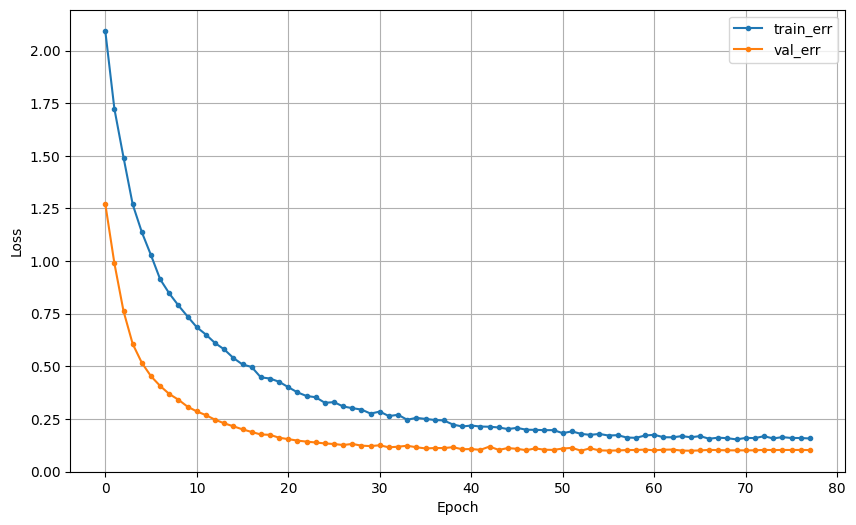

In [9]:
# 학습곡선
# 이 그래프는 제공된 함수
dl_history_plot(model.history.history)

In [10]:
# 예측 및 평가
model.evaluate(x_test, y_test)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9763 - loss: 0.0962


[0.08179480582475662, 0.9809653162956238]